In [1]:
%run ./utility.ipynb

The dataset used in this project is the [Home Equity dataset](https://www.kaggle.com/datasets/ajay1735/hmeq-data/data). This dataset contains baseline and loan performance information for 5,960 recent home equity loans.<br> It contains the following columns:
<ul>
<li>BAD: 1 = client defaulted on loan 0 = loan repaid</li>
<li>LOAN: Amount of the loan request</li>
<li>MORTDUE: Amount due on existing mortgage</li>
<li>VALUE: Value of current property</li>
<li>REASON: DebtCon = debt consolidation, HomeImp = home improvement</li>
<li>JOB: Six occupational categories</li>
<li>YOJ: Years at present job</li>
<li>DEROG: Number of major derogatory reports</li>
<li>DELINQ: Number of delinquent credit lines</li>
<li>CLAGE: Age of oldest trade line in months</li>
<li>NINQ: Number of recent credit lines</li>
<li>CLNO: Number of credit lines</li>
<li>DEBTINC: Debt-to-income ratio</li></ul>

In [2]:
df = pd.read_csv('./data/hmeq.csv')

# Index
1. [General dataset information](#general-dataset-information)
2. [Outliers](#Outliers)
3. [Correlations](#Correlations)
4. [Skew](#Skew)
5. [Features](#Features)

# General dataset information

In [3]:
df.shape

(5960, 13)

In [4]:
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


The features have varying scales, and it might be helpful to standardize them based on the algorithms used.<br>
Additionally, some features appear to be correlated, like JOB and YOJ, if you don't have a job, the years at the current job will also be null. The same correlation can be inferred between REASON - DEBTINC or DEBTINC - JOB ... .

In [5]:
df.dtypes

BAD          int64
LOAN         int64
MORTDUE    float64
VALUE      float64
REASON      object
JOB         object
YOJ        float64
DEROG      float64
DELINQ     float64
CLAGE      float64
NINQ       float64
CLNO       float64
DEBTINC    float64
dtype: object

REASON and JOB are cartegories, we will need to extract the categories of these features before modelling

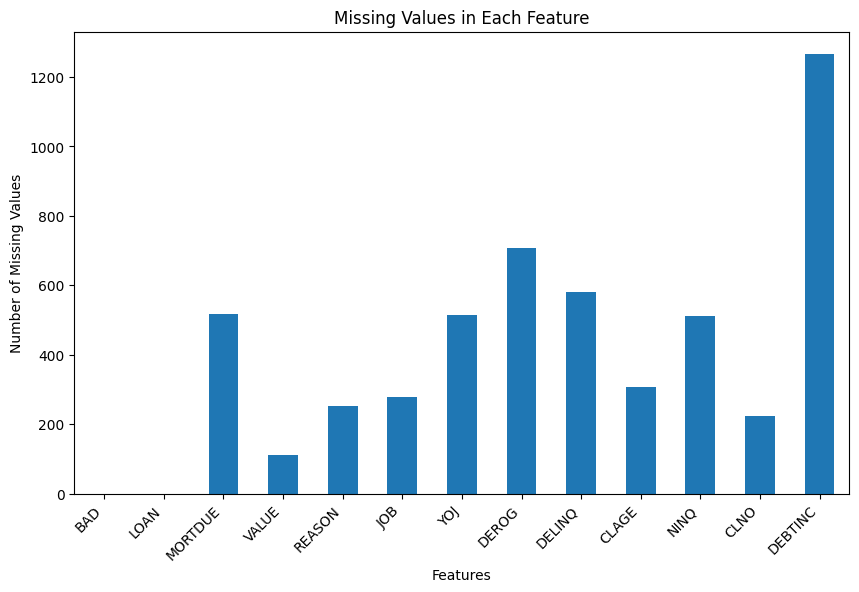

In [34]:
missing_values = df.isnull().sum()

plt.figure(figsize=(10, 6))
missing_values.plot(kind='bar')
plt.title('Missing Values in Each Feature')
plt.xlabel('Features')
plt.ylabel('Number of Missing Values')
plt.xticks(rotation=45, ha='right')
plt.savefig('./images/missing_val.png', bbox_inches='tight')
plt.show()

We see quite a few null values which need to be imputed<br>

In [7]:
df.describe()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,5960.000000,5960.000000,5442.000000,5848.000000,5445.000000,5252.000000,5380.000000,5652.000000,5450.000000,5738.000000,4693.000000
mean,0.199497,18607.969799,73760.817200,101776.048741,8.922268,0.254570,0.449442,179.766275,1.186055,21.296096,33.779915
std,0.399656,11207.480417,44457.609458,57385.775334,7.573982,0.846047,1.127266,85.810092,1.728675,10.138933,8.601746
min,0.000000,1100.000000,2063.000000,8000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524499
25%,0.000000,11100.000000,46276.000000,66075.500000,3.000000,0.000000,0.000000,115.116702,0.000000,15.000000,29.140031
50%,0.000000,16300.000000,65019.000000,89235.500000,7.000000,0.000000,0.000000,173.466667,1.000000,20.000000,34.818262
75%,0.000000,23300.000000,91488.000000,119824.250000,13.000000,0.000000,0.000000,231.562278,2.000000,26.000000,39.003141
max,1.000000,89900.000000,399550.000000,855909.000000,41.000000,10.000000,15.000000,1168.233561,17.000000,71.000000,203.312149


In [8]:
empty_rows = df.index[df.drop(["BAD", "LOAN"], axis=1).isna().all(axis=1)].tolist()
df.iloc[empty_rows]

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1405,0,10800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It appears that rows 3 and 1405 are completely empty

# Outliers

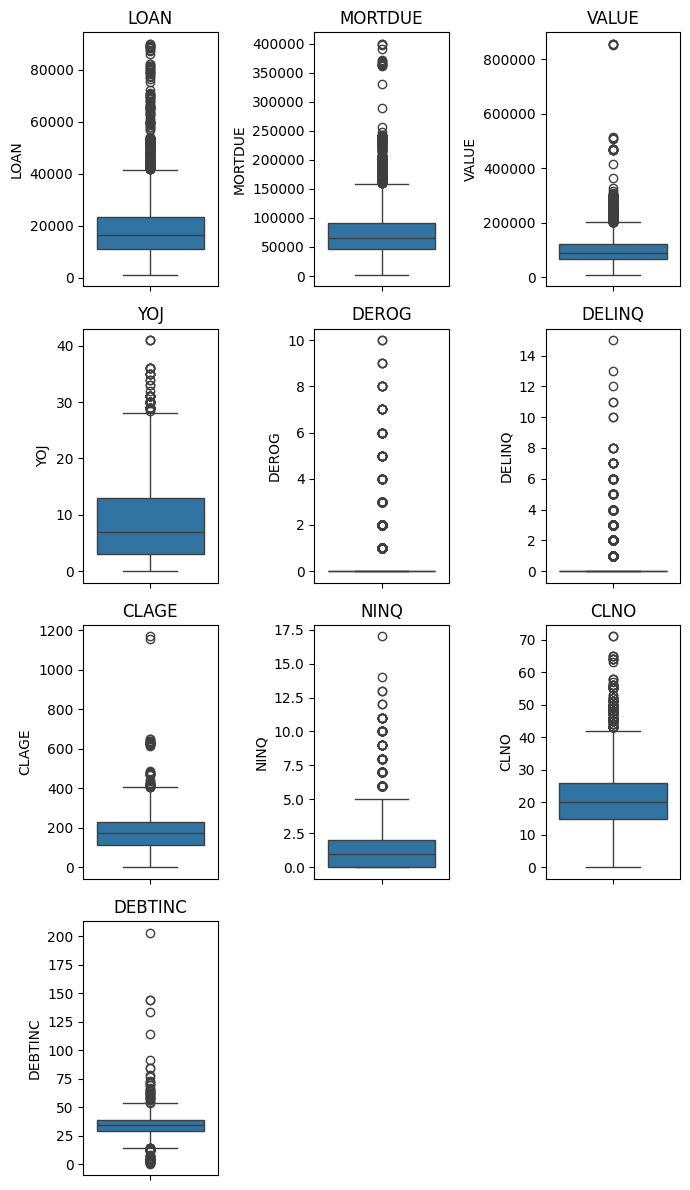

In [25]:
outlier_df = df.drop(["BAD", "JOB", "REASON"], axis=1)
outlier_df = outlier_df[outlier_df.notnull()]
                
num_columns = len(outlier_df.columns)
num_rows = math.ceil(num_columns / 3)
num_cols = 3

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(7, 3*num_rows))
axes = axes.flatten()

for i, column in enumerate(outlier_df.columns):
    sns.boxplot(y=df[column], ax=axes[i])
    axes[i].set_title(column)

for j in range(num_columns, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('./images/outliers.png', bbox_inches='tight')
plt.show()


There don't seem to be any outliers that are clear input errors.<br>

# Correlations

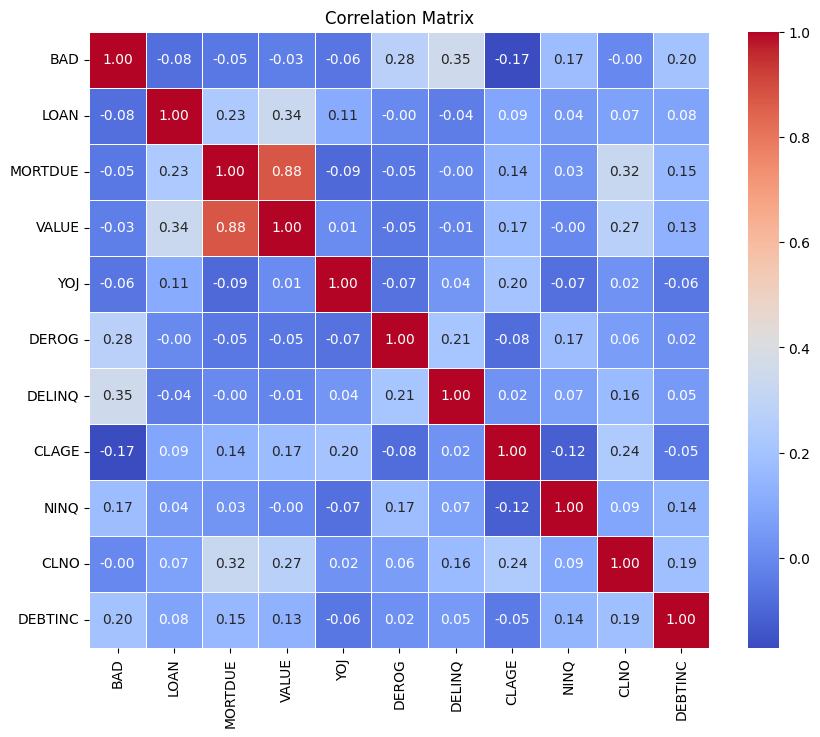

In [26]:
corr_df = df.drop(["JOB", "REASON"], axis=1)
correlation_matrix = corr_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix")
plt.savefig('./images/correlations.png')

We see that DEROG, DELINQ, DEBTINC and NINQ have the highest correlation with the classification which is to be expected.<br>
We also see that VALUE is highly correlated with MORTDUE which was also obvious. We can drop one of these features in subsequent steps since they produce redundant information

# Skew

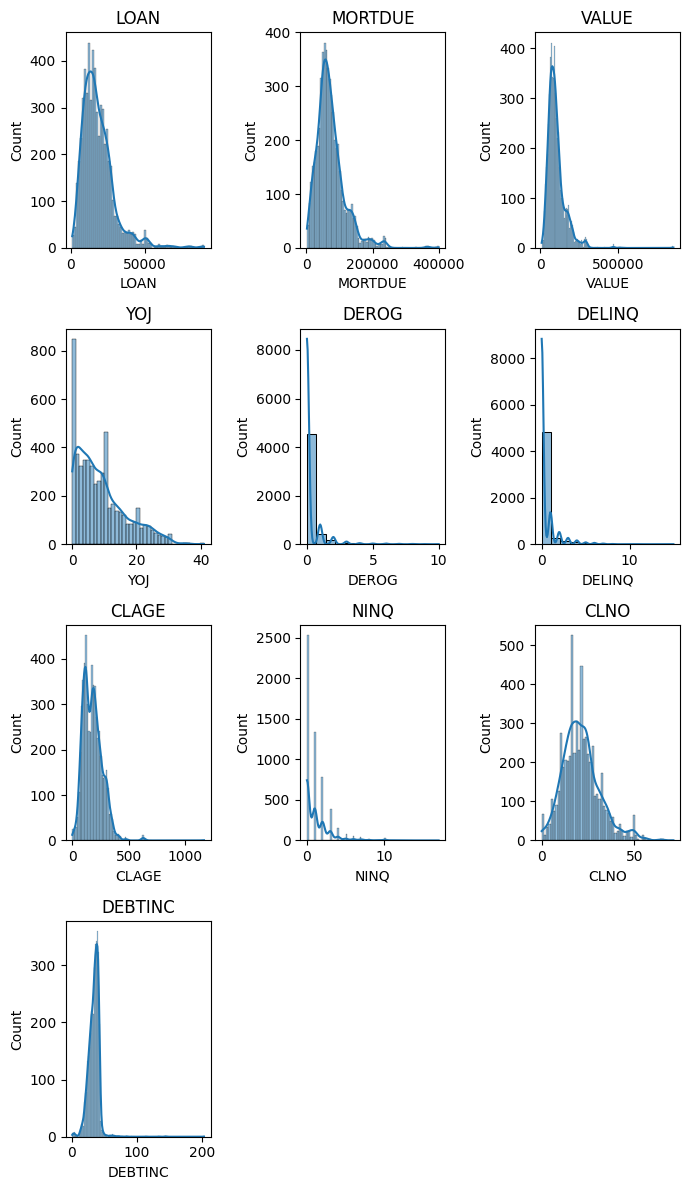

In [11]:
skew_df = df.drop(["BAD", "JOB", "REASON"], axis=1)
skew_df = skew_df[skew_df.notnull()]

num_columns = len(outlier_df.columns)
num_rows = math.ceil(num_columns / 3)
num_cols = 3

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(7, 3*num_rows))
axes = axes.flatten()

for i, column in enumerate(outlier_df.columns):
    sns.histplot(x=df[column], ax=axes[i], kde=True)
    axes[i].set_title(column)

for j in range(num_columns, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [12]:
skew_df.skew().sort_values(ascending=False)

DEROG      5.320870
DELINQ     4.023150
VALUE      3.053344
DEBTINC    2.852353
NINQ       2.621984
LOAN       2.023781
MORTDUE    1.814481
CLAGE      1.343412
YOJ        0.988460
CLNO       0.775052
dtype: float64

Many of the features seem skewed

# Features

In [39]:
class_distribution = df["BAD"].value_counts()
job_distribution = df["JOB"].value_counts()
reason_distribution = df["REASON"].value_counts()

In [73]:
class_distribution.keys

<bound method Series.keys of BAD
0    4771
1    1189
Name: count, dtype: int64>

C:\Users\Arne\AppData\Local\Temp\ipykernel_21936\1682657713.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(job_distribution.index, rotation=45)


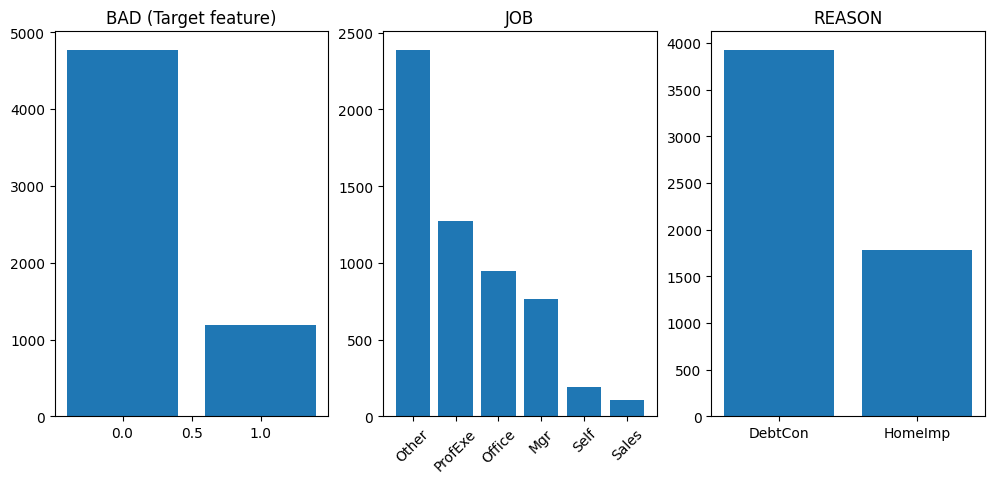

In [78]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))

axs[0].bar(class_distribution.keys(),class_distribution)
axs[0].set_title('BAD (Target feature)')

axs[1].bar(job_distribution.index, job_distribution)
axs[1].set_title('JOB')
axs[1].set_xticklabels(job_distribution.index, rotation=45)


axs[2].bar(reason_distribution.index, reason_distribution)
axs[2].set_title('REASON')

plt.savefig('./images/feature_plots.png')

It appears that our dataset is imbalanced

In [17]:
df[(df["JOB"].isnull()) & - (df["YOJ"].isnull())]

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
10,1,2000,22608.0,NaN,NaN,NaN,18.0,NaN,NaN,NaN,NaN,NaN,NaN
17,1,2200,23030.0,NaN,NaN,NaN,19.0,NaN,NaN,NaN,NaN,NaN,3.711312
27,1,2500,15000.0,20200.0,HomeImp,NaN,18.0,0.0,0.0,136.066667,1.0,19.0,NaN
92,0,4000,NaN,45760.0,HomeImp,NaN,0.0,0.0,0.0,NaN,0.0,0.0,NaN
105,0,4200,44000.0,55085.0,DebtCon,NaN,6.0,NaN,1.0,75.433333,NaN,16.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5943,0,81200,18834.0,108355.0,HomeImp,NaN,28.0,0.0,0.0,139.136329,0.0,14.0,34.042153
5944,0,81400,22344.0,108280.0,HomeImp,NaN,25.0,0.0,0.0,148.114994,0.0,14.0,34.285741
5945,0,81400,21041.0,111304.0,HomeImp,NaN,26.0,0.0,0.0,146.322783,0.0,14.0,32.131373
5946,0,82200,16097.0,111287.0,HomeImp,NaN,26.0,0.0,0.0,142.119979,0.0,14.0,31.743472


Since these entries have no job category specified but have years at current job, it is safe to assumes that either JOB or YOJ is wrong. For these entries I'll impute the JOB as missing

In [18]:
df[- (df["JOB"].isnull()) & (df["YOJ"].isnull())]

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
15,1,2200,24280.0,34687.0,HomeImp,Other,NaN,0.0,1.0,300.866667,0.0,8.0,NaN
24,1,2400,NaN,17180.0,HomeImp,Other,NaN,0.0,0.0,14.566667,3.0,4.0,NaN
29,0,2500,7229.0,44516.0,HomeImp,Self,NaN,0.0,0.0,208.000000,0.0,12.0,NaN
54,1,3200,27200.0,40834.0,HomeImp,Other,NaN,0.0,0.0,298.131564,0.0,7.0,35.553539
74,0,3800,11543.0,46045.0,HomeImp,Self,NaN,0.0,0.0,204.647992,0.0,11.0,42.173166
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5854,0,51500,NaN,90003.0,HomeImp,Other,NaN,0.0,0.0,347.802514,0.0,7.0,25.324002
5862,0,52200,NaN,90240.0,HomeImp,Other,NaN,0.0,0.0,341.828812,0.0,7.0,24.016671
5865,0,52300,NaN,84584.0,HomeImp,Other,NaN,1.0,0.0,350.920996,0.0,7.0,24.355304
5880,0,53700,NaN,84205.0,HomeImp,Other,NaN,0.0,0.0,339.665615,0.0,7.0,22.639940


It's impossible to know if JOB is wrong or if YOJ was not specified thus I'll impute YOJ with the mean for these entries

We don't have a lot of background or related infromation for DEROG, DELINQ and CLAGE so their missing values will just be imputed

In [20]:
df[- (df["NINQ"].isnull()) & (df["CLNO"].isnull())]

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC


NINQ are the recent credit lines so you can't have recent credit lines without having general credit lines (CLNO).

In [21]:
df[(df["NINQ"].isnull()) & -(df["CLNO"].isnull())]

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
95,1,4000,74000.0,93000.0,HomeImp,ProfExe,2.6,1.0,3.0,186.633333,NaN,9.0,NaN
105,0,4200,44000.0,55085.0,DebtCon,NaN,6.0,NaN,1.0,75.433333,NaN,16.0,NaN
127,0,4700,53918.0,59511.0,DebtCon,NaN,6.0,NaN,0.0,54.136477,NaN,15.0,34.416508
145,0,5000,47479.0,61690.0,DebtCon,NaN,5.0,NaN,0.0,65.032969,NaN,16.0,36.699415
169,0,5000,39000.0,50340.0,HomeImp,Office,10.0,NaN,NaN,179.833333,NaN,19.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5759,0,44000,NaN,50760.0,DebtCon,Other,NaN,5.0,NaN,116.437035,NaN,19.0,26.070435
5762,0,44100,NaN,51165.0,DebtCon,Other,NaN,5.0,NaN,130.496983,NaN,19.0,27.105116
5765,0,44500,NaN,50696.0,DebtCon,Other,NaN,5.0,NaN,128.656393,NaN,20.0,28.187140
5808,1,50000,69400.0,163000.0,HomeImp,Other,1.3,0.0,1.0,103.133333,NaN,13.0,NaN


The opposite is true you can have no recent credit lines while having general credit lines. Depending on the banks definition of recent we can use CLAGE (age of oldest trade lin in months) to judge if NINQ is wrong or if their are no recent credit lines.

In [22]:
df[(df["NINQ"].isnull()) & -(df["CLNO"].isnull()) & (df["CLAGE"] < 12 )][["CLAGE", "NINQ", "CLNO"]]

,CLAGE,NINQ,CLNO
691,9.100000,NaN,8.0
1083,2.820786,NaN,7.0
1091,0.507115,NaN,8.0
1122,3.044384,NaN,8.0
1347,9.534143,NaN,7.0
1360,11.963733,NaN,7.0
1572,4.412770,NaN,8.0
4758,10.133333,NaN,41.0
4845,5.243341,NaN,41.0


I'll use 12 months as the definition of recent. If the oldest credit line (CLAGE) is younger than 12 months we can say that all credit lines (CLNO) are recent. Since CLAGE is only the age of the oldest credit line, we can't make any infrences for the cases where CLAGE is more than 12 months and these will be imputed